In [1]:
import math # for sqrt...
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split # for train test split
from sklearn.metrics import mutual_info_score # for mutual information score
from sklearn.metrics import accuracy_score # for accuracy score
from sklearn.metrics import mean_squared_error # for q6
from sklearn.feature_extraction import DictVectorizer # for one-hot encoding
from sklearn.linear_model import LogisticRegression # for log reg
from sklearn.linear_model import Ridge # for q6
import pickle

from sklearn.metrics import roc_auc_score # for hw4 q1
from matplotlib import pyplot as plt # for hw4 q3
%matplotlib inline
from sklearn.model_selection import KFold # for hw4 q5

from tqdm.auto import tqdm # copy-pasted from Alexey for q6

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")
# The goal of this homework is to inspect the output of different evaluation metrics 
# by creating a classification model (target column card).

In [3]:
# Preparation
# Create the target variable by mapping yes to 1 and no to 0.
df['card'] = df['card'].map(dict(yes=1, no=0)) # <-- target
# df['owner'] = df['owner'].map(dict(yes=1, no=0))
# df['selfemp'] = df['selfemp'].map(dict(yes=1, no=0))
# df.head()

In [59]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    df.drop('card', axis = 1),
    df[['card']],
    train_size = 0.8,
    test_size = 0.2,
    random_state = 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    train_size = 0.75,
    test_size = 0.25,
    #shuffle = False,
    random_state = 1)

In [60]:
#y_valid.sum()

In [61]:
# Question 1
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# Let's do that
# For each numerical variable, use it as score and compute AUC with the card variable.
# Use the training dataset for that.
# If your AUC is < 0.5, invert this variable by putting "-" in front
roc_auc_reports = roc_auc_score(y_train, -X_train[['reports']])
print("AUC for variable 'reports': ", roc_auc_reports)
roc_auc_dependents = roc_auc_score(y_train, -X_train[['dependents']])
print("AUC for variable 'dependents': ", roc_auc_dependents)
roc_auc_active = roc_auc_score(y_train, X_train[['active']])
print("AUC for variable 'active': ", roc_auc_active)
roc_auc_share = roc_auc_score(y_train, X_train[['share']])
print("AUC for variable 'share': ", roc_auc_share)

# numerical variables: reports, age, income, share, expenditure, dependents, months, active
# relevant for question: reports, dependents, active, share
# (e.g. -df_train['expenditure'])
# AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?
# reports
# dependents
# active
# --> share <--

AUC for variable 'reports':  0.7166629860689376
AUC for variable 'dependents':  0.5327757227773791
AUC for variable 'active':  0.6043173411362006
AUC for variable 'share':  0.989183643423692


In [62]:
# Training the model
# From now on, use these columns only:
columns_to_use = ["reports", 
                  "age", "income", 
                  "share", 
                  "expenditure", 
                  "dependents", 
                  "months", 
                  "majorcards", 
                  "active", 
                  "owner", 
                  "selfemp"]
columns_to_use
X_train_valid_q2 = X_train_valid[columns_to_use].copy() # added for q5
X_train_q2 = X_train[columns_to_use].copy()
X_valid_q2 = X_valid[columns_to_use].copy()
X_test_q2 = X_test[columns_to_use].copy()
# Apply one-hot-encoding using DictVectorizer 

In [63]:
X_train_q2.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
1105,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17,no,no
431,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4,yes,no
407,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7,no,no
1217,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9,yes,no
1133,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4,yes,no


In [64]:
train_dict = X_train_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train_q2 = dv.transform(train_dict)

valid_dict = X_valid_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(valid_dict)
X_valid_q2 = dv.transform(valid_dict)

test_dict = X_test_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test_q2 = dv.transform(test_dict)


In [65]:
# and train the logistic regression with these parameters:
model_q2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model_q2.fit(X_train_q2, y_train.values.ravel())
card_valid_pred_q2 = model_q2.predict(X_valid_q2)

In [66]:
card_valid_pred_proba_q2 = model_q2.predict_proba(X_valid_q2)[:, 1]#.round(3)
#card_valid_pred_proba

In [67]:
# Question 2
# What's the AUC of this model on the validation dataset? (round to 3 digits)

round(roc_auc_score(y_valid, card_valid_pred_proba_q2),3)

# 0.615
# 0.515
# 0.715
# --> 0.995 <-- closest

0.995

In [68]:

#print(np.array(card_valid_pred_proba).shape)
#print(np.array(y_valid.values).shape)

In [69]:
y_valid.card.value_counts()

1    211
0     53
Name: card, dtype: int64

In [70]:
# Question 3
# Now let's compute precision and recall for our model.
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
thresholds
# For each threshold, compute precision and recall
precision = []
recall = []

for t in thresholds:
    true_positive = ((card_valid_pred_proba_q2 >= t) &
                     (y_valid.card.values == 1)).sum()
    # print(true_positive)
    false_positive = ((card_valid_pred_proba_q2 >= t) &
                      (y_valid.card.values == 0)).sum()
    # print(false_positive)
    false_negative = ((card_valid_pred_proba_q2 < t) &
                      (y_valid.card.values == 1)).sum()
    # print(false_negative)
    true_negative = ((card_valid_pred_proba_q2 < t) &
                     (y_valid.card.values == 0)).sum()
    # print(true_negative)
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    precision.append(prec)
    recall.append(reca)
    #print('%0.2f %d %d %d %d %0.2f %0.3f' % (t, 
    #                                         true_positive, false_positive, false_negative, true_negative, 
    #                                         prec, reca))


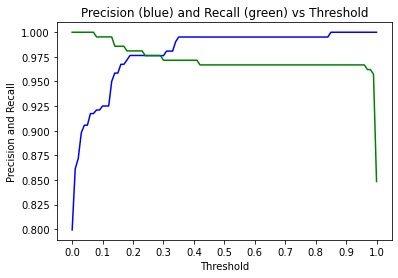

In [71]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='green')

plt.title('Precision (blue) and Recall (green) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [72]:
# Plot them
# At which threshold precision and recall curves intersect?
# 0.1
# --> 0.3 <--
# 0.6
# 0.8

In [73]:
# Question 4
# Precision and recall are conflicting - when one grows, the other goes down. 
# That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1:
# F1 = 2 * P * R / (P + R)
# Where P is precision and R is recall.
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
f1 = []
for t in thresholds:
    
    true_positive = ((card_valid_pred_proba_q2 >= t) & (y_valid.card.values == 1)).sum()
    false_positive = ((card_valid_pred_proba_q2 >= t) & (y_valid.card.values == 0)).sum()
    false_negative = ((card_valid_pred_proba_q2 < t) & (y_valid.card.values == 1)).sum()
    true_negative = ((card_valid_pred_proba_q2 < t) & (y_valid.card.values == 0)).sum()
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    f1_t = 2 * prec * reca / ( prec + reca )
    f1.append((t, true_positive, false_positive, false_negative, true_negative, f1_t))
    
    #print('%0.2f %0.3f' % (t, f1_t))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'f1']
df_scores = pd.DataFrame(f1, columns=columns)

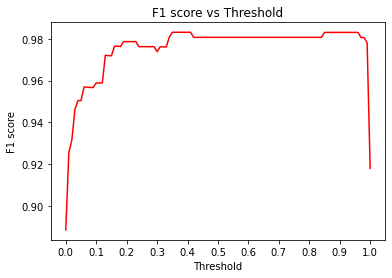

In [74]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.f1, color='red')

plt.title('F1 score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 score')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [75]:
# At which threshold F1 is maximal?
df_scores.sort_values('f1',ascending=False).head(1)
# 0.1
# --> 0.4 <--
# 0.6
# 0.7

,threshold,tp,fp,fn,tn,f1
39,0.39,205,1,6,52,0.983213


In [76]:
# Question 5
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

# KFold(n_splits=5, shuffle=True, random_state=1)
# Iterate over different folds of df_full_train
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation

# copy-pasting functions train() and predict() from slides notebook to make below more easily readyble
def train(df_train, y_train, C=1.0):
    # dicts = df_train[categorical + numerical].to_dict(orient='records')
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    # dicts = df[categorical + numerical].to_dict(orient='records')
    dicts = df.to_dict(orient='records') # not doing above here, all are cat or num

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [77]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
# kfold.split(X_train)

In [83]:
# Iterate over different folds of df_full_train

scores = []

for train_idx, val_idx in kfold.split(X_train_valid_q2):
    
    df_train = X_train_valid_q2.iloc[train_idx]
    df_val = X_train_valid_q2.iloc[val_idx]

    y_train = y_train_valid.card.values[train_idx]
    y_val = y_train_valid.card.values[val_idx]

    dv, model = train(df_train, y_train, C=1)
    
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

(844, 11) (211, 11)
(844,) (211,)
(844, 11) (211, 11)
(844,) (211,)
(844, 11) (211, 11)
(844,) (211,)
(844, 11) (211, 11)
(844,) (211,)
(844, 11) (211, 11)
(844,) (211,)


In [87]:
print('The standard deviation of the AUC scores across folds is', round(np.std(scores), 3))

The standard deviation of the AUC scores across folds is 0.003


In [ ]:
# How large is standard devidation of the AUC scores across different folds?
# --> 0.003 <--
# 0.014
# 0.09
# 0.24

In [89]:
# Question 6
# Now let's use 5-Fold cross-validation to find the best parameter C
# Iterate over the following C values: [0.01, 0.1, 1, 10]
# Initialize KFold with the same parameters as previously
# Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(X_train_valid_q2):
        df_train = X_train_valid_q2.iloc[train_idx]
        df_val = X_train_valid_q2.iloc[val_idx]

        y_train = y_train_valid.card.values[train_idx]
        y_val = y_train_valid.card.values[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?
# 0.01
# --> 0.1 <-- see below
# 1
# 10
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

# best (highest) mean score: C=0.1 and C=10 --> tied!
# std for C=0.1 and C=10: 0.003 --> still tied!
# smallest C between tied candidates: 0.1

C=0.01, 0.995 +- 0.004
C= 0.1, 0.997 +- 0.003
C=   1, 0.996 +- 0.003
C=  10, 0.997 +- 0.003
